In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import esmtools as et
from esmtools import stats

import shapefile
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gp
import regionmask
import matplotlib.patches as mpatches

In [2]:
# Open dataset for co3satarag
dir = '/home/jovyan/SOARS_2021/Data/CESM2/'
fn_co3satarag = 'co3satarag_Omon_CESM2_omip2_r1i1p1f1_gr_030601-036612.nc'

# Open dataset for co3
fn_co3 = 'co3_Omon_CESM2_omip2_r1i1p1f1_gr_030601-036612.nc'

data_co3satarag = xr.open_dataset(dir+fn_co3satarag)
data_co3 = xr.open_dataset(dir+fn_co3)

/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'co3satarag' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'co3' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [3]:
# Change the time to be from DatetimeNoLeap to a Datetime64
data_co3satarag['time'] = np.arange('1958-01-01','2019-01-01',dtype = 'datetime64[M]')
data_co3['time'] = np.arange('1958-01-01','2019-01-01',dtype = 'datetime64[M]')

In [4]:
# select dimensions!
data_co3satarag['time'] = pd.date_range("1958-01", "2018-12", freq="MS")
co3satarag = data_co3satarag['co3satarag']
co3satarag = co3satarag.sel(lon=slice(190,270),lat=slice(-10,70), lev=0)

data_co3['time'] = pd.date_range("1958-01", "2018-12", freq="MS")
co3 = data_co3['co3']
co3 = co3.sel(lon=slice(190,270),lat=slice(-10,70), lev=0)

co3

<xarray.DataArray 'co3' (time: 732, lat: 80, lon: 80)>
[4684800 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2018-12-01
    lev      float64 0.0
  * lat      (lat) float64 -9.5 -8.5 -7.5 -6.5 -5.5 ... 65.5 66.5 67.5 68.5 69.5
  * lon      (lon) float64 190.5 191.5 192.5 193.5 ... 266.5 267.5 268.5 269.5
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    Mole concentration (number of moles per unit volume: mola...
    frequency:      mon
    id:             co3
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Carbonate Ion Concentration
    type:           real
    units:          mol m-3
    variable_id:    co3

In [5]:
omg_a = co3 / co3satarag

In [6]:
# remove long term trend for each grid cell
var = stats.rm_poly(omg_a,order=2,dim='time',nan_policy='drop')
#var = omg_a

In [7]:
# 1982-2010 period
base = var.sel(time=slice('1982-01','2010-12'))
tos_base = base

In [8]:
# Blob period
blob = var.sel(time=slice('2013-07','2016-06'))
tos_blob = blob

In [9]:
# Difference between the two periods
blob_anom = blob.groupby('time.month') - base.groupby('time.month').mean()

In [10]:
# Resample to two month resolution
cesm = blob_anom.resample(time='2M').mean()
cesm

<xarray.DataArray (lat: 80, lon: 80, time: 19)>
array([[[-0.04245736, -0.0324126 , -0.03745523, ...,  0.02538725,
          0.02145964,  0.01746304],
        [-0.04451257, -0.03604383, -0.03886187, ...,  0.02818138,
          0.0246212 ,  0.02215449],
        [-0.04772549, -0.03924613, -0.03930326, ...,  0.03204669,
          0.02806066,  0.02843242],
        ...,
        [-0.06669198, -0.06031987, -0.06021843, ...,  0.19645541,
          0.22534637,  0.25575402],
        [-0.06336581, -0.05748147, -0.05880373, ...,  0.19455697,
          0.22619609,  0.2595718 ],
        [-0.05919697, -0.052762  , -0.05719557, ...,  0.19236949,
          0.22706376,  0.26459632]],

       [[-0.04904581, -0.03273791, -0.02497809, ...,  0.04217102,
          0.03740285,  0.04162315],
        [-0.04880702, -0.03434674, -0.02404757, ...,  0.04623783,
          0.04172837,  0.04659903],
        [-0.04943304, -0.03545165, -0.02251575, ...,  0.05235025,
          0.04657834,  0.05329306],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.00208874, -0.05249684, -0.03215749, ..., -0.0043318 ,
          0.00774907, -0.05107232],
        [ 0.00483363, -0.05736656, -0.02286412, ..., -0.00552928,
          0.00666305, -0.06275272],
        [ 0.00686387, -0.0596083 , -0.01500085, ..., -0.00624068,
          0.00612589, -0.0658598 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 0.0433521 ,  0.03870045,  0.01408619, ...,  0.01483739,
          0.01666368,  0.00715278]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-31 2013-09-30 ... 2016-07-31
    lev      float64 0.0
  * lat      (lat) float64 -9.5 -8.5 -7.5 -6.5 -5.5 ... 65.5 66.5 67.5 68.5 69.5
  * lon      (lon) float64 190.5 191.5 192.5 193.5 ... 266.5 267.5 268.5 269.5

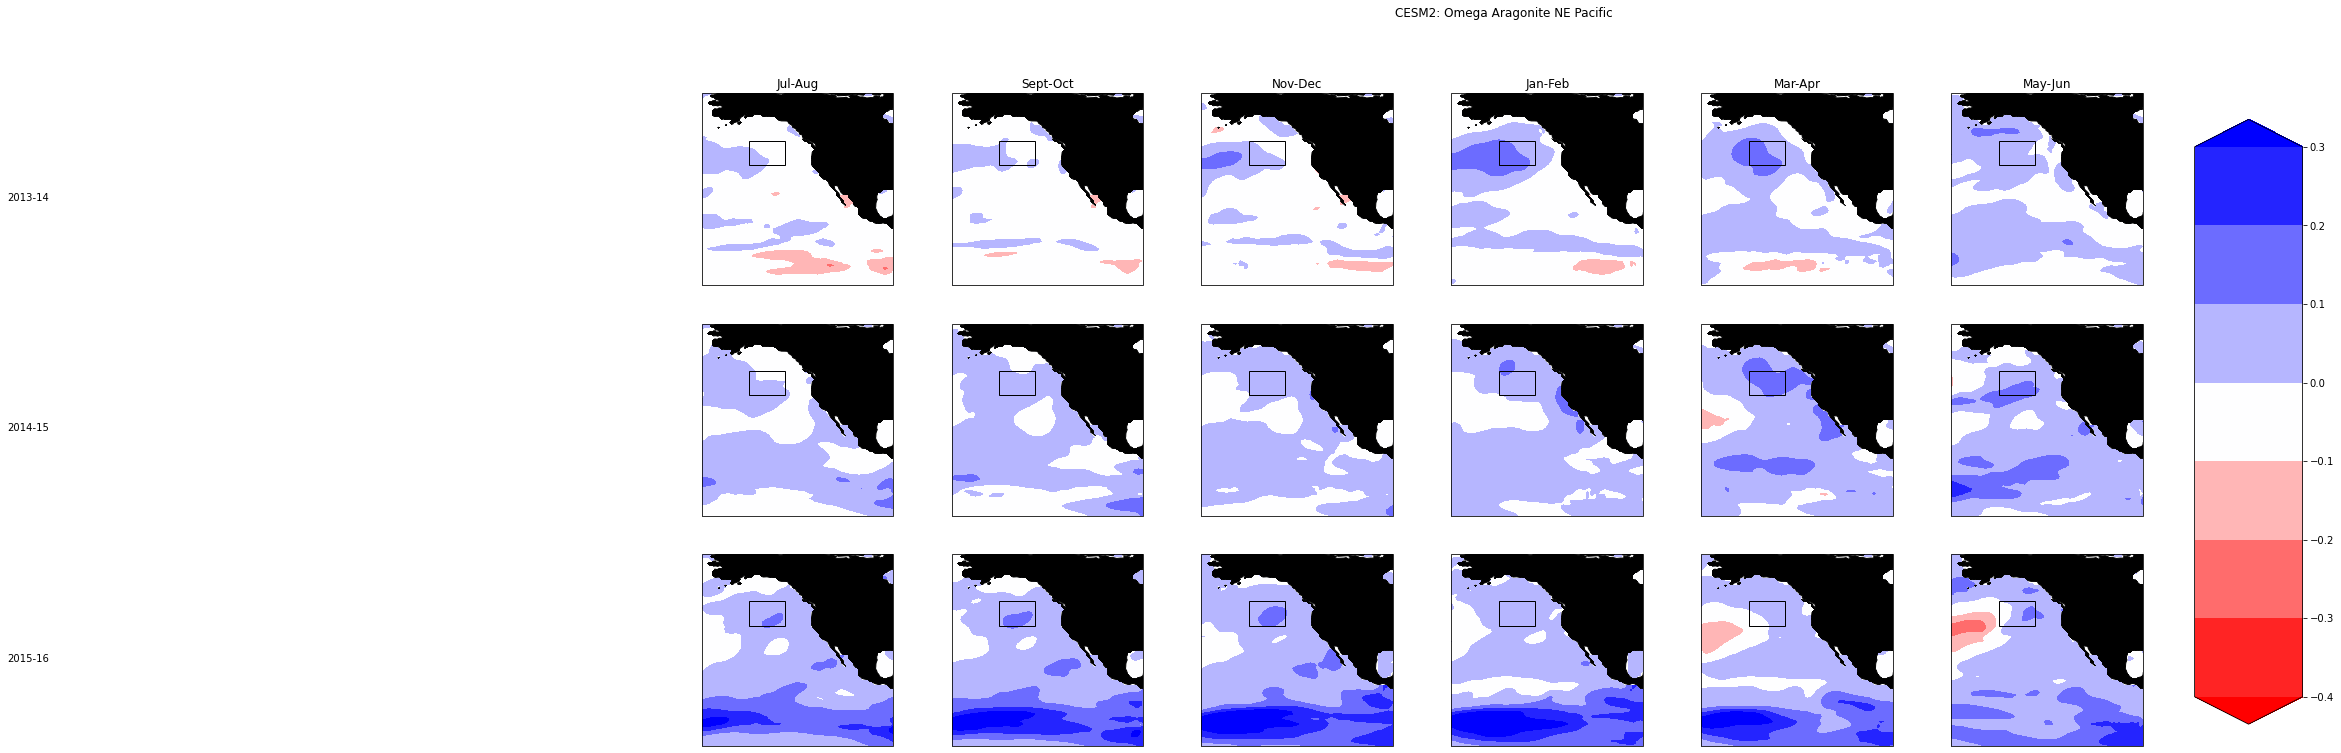

In [11]:
def panels(data,description,variable,depth,lower_bound,upper_bound, step,cmap):
    f, axs = plt.subplots(nrows=3,ncols=6,figsize=(30,12),
                          subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180))) 
    axs = axs.flatten()
    for i in range(0,18):
        im = axs[i].contourf(cesm.lon, cesm.lat, cesm.isel(time=i),
                         transform=ccrs.PlateCarree(), 
                         cmap=cmap,
                         levels=np.arange(lower_bound, upper_bound, step),
                         extend='both')
        axs[i].add_feature(cfeature.LAND, color='k')
        axs[i].add_patch(mpatches.Rectangle(xy=[210, 40], width=15, height=10,
                                    edgecolor='k',
                                    facecolor='none',
                                    transform=ccrs.PlateCarree())
                 )
    plt.suptitle("CESM2: " + description + " " + variable + " " + depth) # + " (de-trended)")
    axs[0].set_title("Jul-Aug"); axs[1].set_title("Sept-Oct")
    axs[2].set_title("Nov-Dec"); axs[3].set_title("Jan-Feb")
    axs[4].set_title("Mar-Apr"); axs[5].set_title("May-Jun")
    plt.text(-790,215,'2013-14')
    plt.text(-790,120,'2014-15')
    plt.text(-790,25,'2015-16')
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.82, 0.15, 0.05, 0.7])
    f.colorbar(im, cax=cbar_ax,fraction=0.046,pad=0.04)
    
panels(omg_a,'Omega Aragonite','NE','Pacific',-0.4,0.4, 0.1,'bwr_r')